In [1]:
import cv2
import bm3d
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from skimage.restoration import estimate_sigma
from torch.utils.data import DataLoader

from eprocessing.dataload import ImageDataset
from modelbuild.denoiser import DivergentRestorer
from eprocessing.etransforms import Scale, RandCrop, AddAWGN
from emetrics.metrics import SSIMMetric, PSNRMetric, SCCMetric, UIQMetric

In [2]:
DECONV1 = {'kern_size': (),
         'max_iters': 100,
         'lmbda': 0.02,
         'iso': True}
DECONV2 = {'kern_size': (),
         'max_iters': 100,
         'rho': 0.004,
         'iso': True}

device = 'cuda'
modelp = Path('D:/Projects/torch-admm-deconv/trained_models/latest/denoiser_gopro_divergent_attention_wconvs_hide_epoch20_vloss0.0193.tar')
MODEL = DivergentRestorer(3, 2, 3,
                          3, 4, 86,
                          86, 8,
                          output_activation=torch.nn.Sigmoid(), admms=[DECONV1, DECONV2])
model_d = torch.load(modelp, weights_only=False)
MODEL.load_state_dict(model_d['model_state_dict'])
MODEL = MODEL.to(device)
MODEL = MODEL.eval()

In [6]:
def run_bm3d(x: torch.Tensor) -> torch.Tensor:
    x_arr = np.transpose(x.numpy()[0], (1, 2, 0))
    estimated_std = estimate_sigma(x_arr, channel_axis=-1)
    y_est = bm3d.bm3d(x_arr, estimated_std)
    y_est = y_est.astype(np.float32)
    return torch.from_numpy(np.transpose(y_est, (2, 0, 1)))[torch.newaxis, ...]

In [6]:
def run_model(x: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        x_device = x.to(device)
        y_est = MODEL(x_device)
        return y_est.detach().cpu()

In [7]:
def eval_models(dataloader: DataLoader, save_results_path: Path):
    metrics = [SSIMMetric('cpu'), PSNRMetric('cpu'), SCCMetric('cpu'), UIQMetric('cpu')]
    clean = save_results_path / 'clean'
    x_noisy_p = save_results_path / 'noisy'
    bm3d_res_p = save_results_path / 'bm3d'
    model_res_p = save_results_path / 'model'
    
    clean.mkdir(exist_ok=True)
    x_noisy_p.mkdir(exist_ok=True)
    bm3d_res_p.mkdir(exist_ok=True)
    model_res_p.mkdir(exist_ok=True)
    
    bm3d_metrics = {metric.m_name: [] for metric in metrics}
    mode_metrics = {metric.m_name: [] for metric in metrics}
    for batch_idx, (x, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        y_bm3d = run_bm3d(x)
        y_mode = run_model(x)
        
        for metric in metrics:
            bm3d_metrics[metric.m_name].append(metric(y_bm3d, y).numpy())
            mode_metrics[metric.m_name].append(metric(y_mode, y).numpy())
            
        x = torch.clamp(x, 0, 1)
        y_bm3d = torch.clamp(y_bm3d, 0, 1)
        y_mode = torch.clamp(y_mode, 0, 1)
            
        y = np.transpose(y[0].to('cpu').detach().numpy() * 255, (1, 2, 0))
        y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
        x = np.transpose(x[0].to('cpu').detach().numpy() * 255, (1, 2, 0))
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        y_mode = np.transpose(y_mode[0].to('cpu').detach().numpy() * 255, (1, 2, 0))
        y_mode = cv2.cvtColor(y_mode, cv2.COLOR_BGR2RGB)
        y_bm3d = np.transpose(y_bm3d[0].to('cpu').detach().numpy() * 255, (1, 2, 0))
        y_bm3d = cv2.cvtColor(y_bm3d, cv2.COLOR_BGR2RGB)
        
        cv2.imwrite((clean / f'{batch_idx}.png').resolve(), y)
        cv2.imwrite((x_noisy_p / f'{batch_idx}.png').resolve(), x)
        cv2.imwrite((bm3d_res_p / f'{batch_idx}.png').resolve(), y_bm3d)
        cv2.imwrite((model_res_p / f'{batch_idx}.png').resolve(), y_mode)
        
    pd.DataFrame(bm3d_metrics).to_csv(bm3d_res_p / 'metrics.csv')
    pd.DataFrame(mode_metrics).to_csv(model_res_p / 'metrics.csv')

## Set up DataLoader

In [8]:
xp = Path('D:/Projects/datasets/GoPro/GoPro_Large/orig_blur/awgn-0-0/test/y')
yp = Path('D:/Projects/datasets/GoPro/GoPro_Large/orig_blur/awgn-0-0/test/y')
res_path = Path(r'../test_imgs/bm3d_vs_model_255')
res_path.mkdir(exist_ok=True)
im_shape = (256,256)
min_std, max_std = 15, 16
imd = ImageDataset(xp, yp, transforms=[Scale(), RandCrop(im_shape), AddAWGN(std_range=(min_std, max_std), both=False)])
im_loader = torch.utils.data.DataLoader(imd, shuffle=True, batch_size=1)

In [9]:
eval_models(im_loader, res_path)

  0%|          | 0/1111 [00:00<?, ?it/s]

[0.056309852953665696, 0.057991307197920325, 0.06106442291105653]


  0%|          | 1/1111 [00:03<1:06:40,  3.60s/it]

[0.04467353719205681, 0.046571807178750674, 0.042290654527530884]


  0%|          | 2/1111 [00:06<1:03:49,  3.45s/it]

[0.060151793003547484, 0.0607078776631157, 0.06017334975519667]


  0%|          | 2/1111 [00:09<1:27:34,  4.74s/it]

KeyboardInterrupt



## Plot results

In [40]:
bm3d_df = pd.read_csv(res_path / 'bm3d' / 'metrics.csv')
model_df = pd.read_csv(res_path / 'model' / 'metrics.csv')

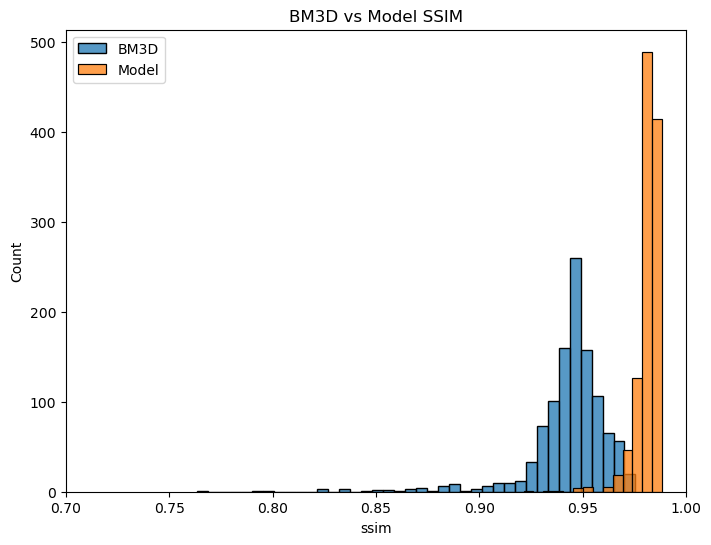

In [39]:
plt.figure(figsize=(8, 6))
sns.histplot(bm3d_df.ssim, bins=40, label='BM3D')
sns.histplot(model_df.ssim, bins=14, label='Model')
plt.xlim(0.7, 1)
plt.title('BM3D vs Model SSIM')
plt.legend()
plt.show()

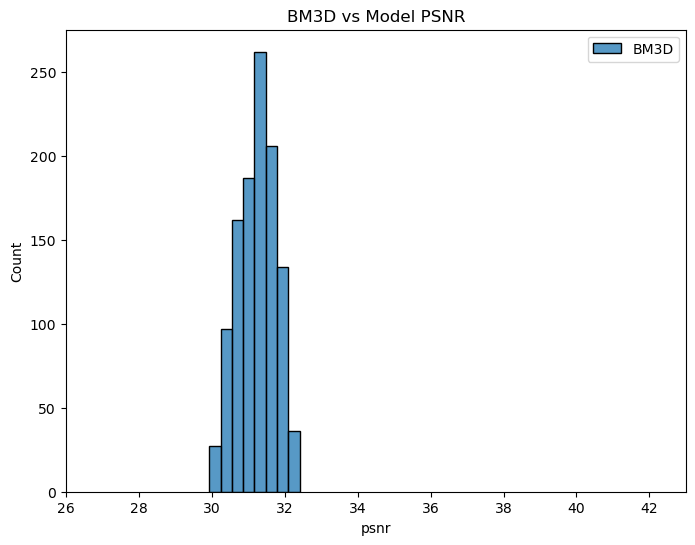

In [41]:
plt.figure(figsize=(8, 6))
sns.histplot(bm3d_df.psnr, bins=8, label='BM3D')
sns.histplot(model_df.psnr, bins=50, label='Model')
plt.xlim(26, 43)
plt.title('BM3D vs Model PSNR')
plt.legend()
plt.show()

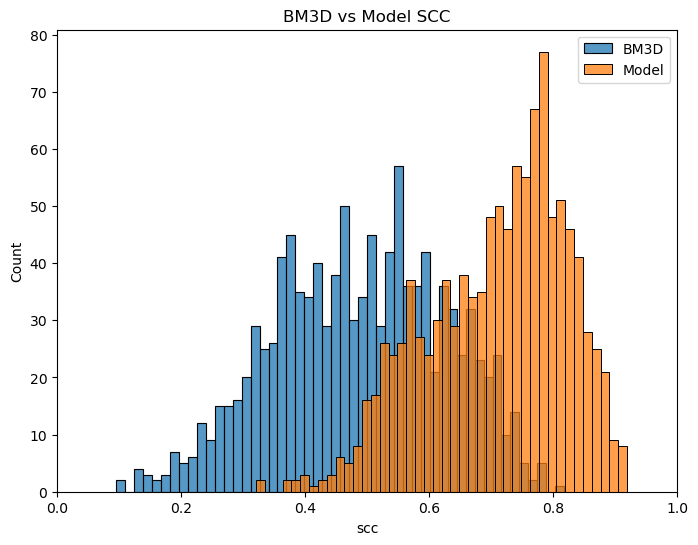

In [38]:
plt.figure(figsize=(8, 6))
sns.histplot(bm3d_df.scc, bins=50, label='BM3D')
sns.histplot(model_df.scc, bins=42, label='Model')
plt.xlim(0, 1)
plt.title('BM3D vs Model SCC')
plt.legend()
plt.show()